In [1]:
import pathlib
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.constant import DATA_DIR, DATABASE_DIR, MAIN_DIR
from src.database import DB
from src.database.queries import *
from src.instance.InstanceList import InstanceList
from src.instance.TSP_Instance import TSP_from_index_file
from src.solver.TSP_LKH_Solver import TSP_LKH_Solver

plt.rcParams['font.family'] = 'Times New Roman'
pd.options.display.max_colwidth = 200
BASE_DIR = MAIN_DIR / "_archive" / "experiments" / "2025-03-05"

## loading

In [2]:
@dataclass
class CutOff:
    cost_600: float
    time_600: float
    cost_400: float
    time_400: float
    cost_200: float
    time_200: float
    cost_100: float
    time_100: float
    cost_50: float
    time_50: float
    label: str

    @property
    def dir(self):
        return BASE_DIR / self.label


cut_offs = [
    CutOff(
        cost_600=100.0,
        time_600=10.0,
        cost_400=41.0,
        time_400=4.1,
        cost_200=8.9,
        time_200=0.89,
        cost_100=1.9,
        time_100=0.19,
        cost_50=0.4,
        time_50=0.04,
        label="10",
    ),
    CutOff(
        cost_600=53.1,
        time_600=5.31,
        cost_400=21.8,
        time_400=2.18,
        cost_200=4.7,
        time_200=0.47,
        cost_100=1.0,
        time_100=0.10,
        cost_50=0.2,
        time_50=0.02,
        label="531",
    ),
    CutOff(
        cost_600=26.6,
        time_600=2.66,
        cost_400=10.9,
        time_400=1.09,
        cost_200=2.3,
        time_200=0.23,
        cost_100=0.5,
        time_100=0.05,
        cost_50=0.1,
        time_50=0.01,
        label="266",
    ),
]

cut_offs

[CutOff(cost_600=100.0, time_600=10.0, cost_400=41.0, time_400=4.1, cost_200=8.9, time_200=0.89, cost_100=1.9, time_100=0.19, cost_50=0.4, time_50=0.04, label='10'),
 CutOff(cost_600=53.1, time_600=5.31, cost_400=21.8, time_400=2.18, cost_200=4.7, time_200=0.47, cost_100=1.0, time_100=0.1, cost_50=0.2, time_50=0.02, label='531'),
 CutOff(cost_600=26.6, time_600=2.66, cost_400=10.9, time_400=1.09, cost_200=2.3, time_200=0.23, cost_100=0.5, time_100=0.05, cost_50=0.1, time_50=0.01, label='266')]

In [3]:
records = []
for cut_off in cut_offs:
    for n in ["30", "250", "500"]:
        for tsp_size in ["50", "100", "200", "400", "600"]:
            dir_ = cut_off.dir / tsp_size / "database"
            databases = list(dir_.glob(f"run-plain-{n}-*.db"))

            for db_path in databases:
                db = DB(db_path)
                try:
                    instances = pd.read_sql_query("SELECT * FROM instances", db._conn)
                    time_train = instances.loc[instances["filepath"].str.contains("TRAIN"), "max_time"].mean()
                    time_test = instances.loc[instances["filepath"].str.contains("TEST"), "max_time"].mean()
            
                    record = {
                        "label": cut_off.label,
                        "n": n,
                        "tsp_size": tsp_size,
                        "db_path": db_path,
                        "time_train": time_train,
                        "time_test": time_test,
                    }
                    records.append(record)

                except Exception as e:
                    pass 

df = pd.DataFrame(records)
df['label'] = pd.Categorical(df['label'], categories=["10", "531", "266"], ordered=True)
df['n'] = pd.Categorical(df['n'], categories=["30", "250", "500"], ordered=True)
df['tsp_size'] = pd.Categorical(df['tsp_size'], categories=["50", "100", "200", "400", "600"], ordered=True)
df["db_path"] = df["db_path"].astype(str)
df["db_path"] = df["db_path"].apply(lambda x: x[94:])
df.groupby(["label", "n", "tsp_size"])[["time_train", "time_test"]].mean()              

time_train  time_test
label n   tsp_size                       
10    30  50              0.04      10.00
          100             0.19      10.00
          200             0.89      10.00
          400             4.10      10.00
          600              NaN        NaN
      250 50              0.04      10.00
          100             0.19      10.00
          200             0.89      10.00
          400             4.10      10.00
          600              NaN        NaN
      500 50              0.04      10.00
          100             0.19      10.00
          200             0.89      10.00
          400             4.10      10.00
          600              NaN        NaN
531   30  50              0.02       5.31
          100             0.10       5.31
          200             0.47       5.31
          400             2.18       5.31
          600             5.31       5.31
      250 50              0.02       5.31
          100             0.10       5.31
          200             0.47       5.31
          400             2.18       5.31
          600             5.31       5.31
      500 50              0.02       5.31
          100             0.10       5.31
          200             0.47       5.31
          400             2.18       5.31
          600             5.31       5.31
266   30  50              0.01       2.66
          100              NaN        NaN
          200             0.23       2.66
          400             1.09       2.66
          600             2.66       2.66
      250 50              0.01       2.66
          100              NaN        NaN
          200             0.23       2.66
          400             1.09       2.66
          600             2.66       2.66
      500 50              0.01       2.66
          100              NaN        NaN
          200             0.23       2.66
          400             1.09       2.66
          600             2.66       2.66

In [ ]:
records = []

for cut_off in cut_offs:
    for tsp_size in ["50", "100", "200", "400", "600"]:
        for n in ["30", "250", "500"]:
            dir_ = cut_off.dir / tsp_size / "database"
            databases = list(dir_.glob(f"run-plain-{n}-*.db"))

            for db_path in databases:
                db = DB(db_path)
                try:
                    results = pd.read_sql_query("SELECT * FROM results", db._conn)
                    instances = pd.read_sql_query("SELECT * FROM instances", db._conn)
                    if "max_cost" not in instances.columns:
                        instances["max_cost"] = cut_off.cost_600
                except Exception as e:
                    print(db_path, e)
                    raise e

                # test_costs
                test_costs = (
                    results.loc[results["prefix"].str.startswith("test")]
                    .groupby(["instance_id", "prefix"])["cost"]
                    .min()
                    .reset_index()
                    .groupby("instance_id")["cost"]
                )


                # cost skip cut-offs
                def _cost_skip_cutoff(x):
                    count = x.shape[0]
                    x = x[x < cut_off.cost_600]
                    x = x.sort_values()
                    idx = count // 2
                    if x.shape[0] == 0:
                        return cut_off.time_600
                    if x.shape[0] <= idx:
                        return x.iloc[-1]
                    return x.iloc[idx]

                try:
                    cost_skip_cutoff = test_costs.agg(_cost_skip_cutoff).mean()
                except Exception as e:
                    print(db_path, e)
                    cost_skip_cutoff = np.nan

                # par-10
                def _par10(x):
                    count = x.shape[0]
                    x = x.sort_values()
                    idx = count // 2
                    return x.iloc[idx]


                par10 = test_costs.agg(_par10).mean()


                # % of cut-offs
                def _test_pct_cutoff(x):
                    return (x == cut_off.cost_600).mean()


                test_pct_cutoff = test_costs.agg(_test_pct_cutoff).mean()

                # total cpu time
                config = results.loc[
                    results["prefix"].str.startswith("config")
                    & results["cached"].eq(0)
                    & results["surrogate"].eq(0),
                ].copy()
                config["max_cost"] = config["instance_id"].map(instances.set_index("id")["max_cost"])

                cpu_time = config["time"].sum() / 3600
                train_cost_skip_cutoff = config.loc[config["cost"] < config["max_cost"], "cost"].mean()
                train_pct_cutoff = (config["cost"] == config["max_cost"]).mean()

                # record
                record = {
                    "label": cut_off.label,
                    "n": n,
                    "tsp_size": tsp_size,
                    "db_path": db_path,
                    "cost_skip_cutoff": cost_skip_cutoff,
                    "par10": par10,
                    "test_pct_cutoff": test_pct_cutoff,
                    "cpu_time": cpu_time,
                    "train_cost_skip_cutoff": train_cost_skip_cutoff,
                    "train_pct_cutoff": train_pct_cutoff,
                }
                records.append(record)

df = pd.DataFrame(records)
#

In [7]:
df = pd.DataFrame(records)

In [8]:
df['label'] = pd.Categorical(df['label'], categories=["10", "531", "266"], ordered=True)
df['n'] = pd.Categorical(df['n'], categories=["30", "250", "500"], ordered=True)
df['tsp_size'] = pd.Categorical(df['tsp_size'], categories=["50", "100", "200", "400", "600"], ordered=True)
df["db_path"] = df["db_path"].astype(str)
df["db_path"] = df["db_path"].apply(lambda x: x[94:])

df

,label,n,tsp_size,db_path,cost_skip_cutoff,par10,test_pct_cutoff,cpu_time,train_cost_skip_cutoff,train_pct_cutoff
0,10,30,50,experiments\2025-03-05\10\50\database\run-plain-30-986143.db,3.9840,16.6226,0.1784,0.032006,0.009182,0.532889
1,10,30,50,experiments\2025-03-05\10\50\database\run-plain-30-986144.db,0.5480,0.5480,0.0062,0.030139,0.008872,0.489556
2,10,30,50,experiments\2025-03-05\10\50\database\run-plain-30-986145.db,0.9480,0.9480,0.0102,0.026786,0.007746,0.424222
3,10,30,50,experiments\2025-03-05\10\50\database\run-plain-30-986146.db,0.7014,0.7014,0.0108,0.028286,0.008224,0.453333
4,10,30,50,experiments\2025-03-05\10\50\database\run-plain-30-986147.db,16.4218,73.6450,0.6784,0.029497,0.008335,0.482000
...,...,...,...,...,...,...,...,...,...,...
404,266,500,600,experiments\2025-03-05\266\600\database\run-plain-500-983116.db,0.4212,0.4212,0.0242,49.570819,1.138084,0.815627
405,266,500,600,experiments\2025-03-05\266\600\database\run-plain-500-983117.db,0.5558,1.0350,0.0668,49.494881,1.161130,0.810360
406,266,500,600,experiments\2025-03-05\266\600\database\run-plain-500-983118.db,0.9332,1.8912,0.1126,49.076592,1.113745,0.803187
407,266,500,600,experiments\2025-03-05\266\600\database\run-plain-500-983120.db,0.7958,1.7552,0.0808,49.889047,1.212979,0.816640


In [9]:
df.to_parquet(BASE_DIR / "results.parquet")

## TEST

In [10]:
df = pd.read_parquet(BASE_DIR / "results.parquet")
# df = df.loc[df["tsp_size"] != "200_400_600"]

In [12]:
def _aggregate(col, ratio=False, format="{:.3f}", axis=None):
    _ = df.groupby(["label", "n", "tsp_size"])[col].mean()
    if ratio:
        _ = _.groupby(["label", "n"]).transform(lambda x: x / x.xs("600", level="tsp_size"))
    _ = (
        _.reset_index()
        .sort_values(by=["label", "tsp_size", "n"])
        .reset_index(drop=True)
        .pivot_table(index=["n"], columns=["label", "tsp_size"], values=col)
        .style
        .format(format)
    )
    print(_.to_latex())
    return _.background_gradient(cmap="Reds", axis=axis)

In [13]:
# averaged runtime (skip cut-offs)

_aggregate("cost_skip_cutoff", axis=None)

\begin{tabular}{lrrrrrrrrrrrrrr}
label & \multicolumn{5}{r}{10} & \multicolumn{5}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 50 & 100 & 200 & 400 & 600 & 50 & 100 & 200 & 400 & 600 & 50 & 200 & 400 & 600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 3.536 & 4.123 & 1.190 & 0.832 & 0.755 & 2.611 & 2.465 & 1.225 & 1.096 & 0.859 & 1.389 & 0.907 & 0.776 & 0.718 \\
250 & 2.609 & 0.746 & 1.100 & 0.780 & 0.622 & 1.671 & 1.731 & 1.023 & 0.853 & 0.714 & 2.349 & 0.874 & 0.760 & 0.728 \\
500 & 2.542 & 1.346 & 0.961 & 0.739 & 0.533 & 1.786 & 1.554 & 0.936 & 0.787 & 0.681 & 2.049 & 0.774 & 0.699 & 0.685 \\
\end{tabular}



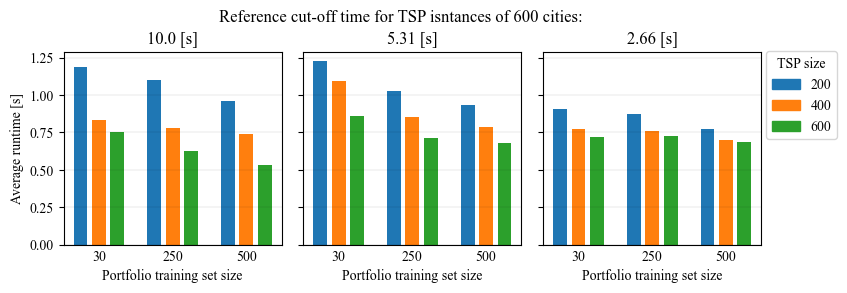

In [29]:
n_to_x = {
    "30": 0,
    "250": 0.8,
    "500": 1.6,
}

tsp_size_to_x = {
    "200": 0.0,
    "400": 0.2,
    "600": 0.4,
}

label_to_time = {
    "10": "10.0",
    "531": "5.31",
    "266": "2.66",
}

tsp_size_to_color = {
    "200": "C0",
    "400": "C1",
    "600": "C2",
}

_ = df.groupby(["label", "n", "tsp_size"])["cost_skip_cutoff"].mean().reset_index().dropna()
_["x"] = _["n"].map(n_to_x).astype(float) + _["tsp_size"].map(tsp_size_to_x).astype(float)
_["color"] = _["tsp_size"].map(tsp_size_to_color)

fig, axs = plt.subplots(1, 3, figsize=(9, 2.5), sharey=True)
for i, (label, group) in enumerate(_.groupby("label")):
    ax = axs[i]
    ax.bar(group["x"], group["cost_skip_cutoff"], width=0.15, color=group["color"], alpha=1.0)
    ax.set_title(f"{label_to_time[label]} [s]")
    ax.set_xticks([0.2, 1, 1.8], labels=["30", "250", "500"])
    ax.tick_params(axis='x', length=0)
    ax.grid(axis='y', color='black', alpha=0.2, lw=0.3, ls="-")
    ax.set_xlabel("Portfolio training set size")

# Create legend
handles = [plt.Rectangle((0,0), 1 , 1, color=tsp_size_to_color[size]) for size in tsp_size_to_color]
labels = ["200", "400", "600"]
axs[2].legend(handles, labels, title="TSP size", loc='upper right', bbox_to_anchor=(1.38, 1.04))

axs[0].set_ylabel("Average runtime [s]")
plt.suptitle("Reference cut-off time for TSP isntances of 600 cities:", y=1.05)
plt.subplots_adjust(wspace=0.1)
plt.savefig(BASE_DIR / "scaling_cost_skip_cutoff.pdf", bbox_inches='tight')
plt.show()

In [85]:
# averaged runtime (skip cut-offs) --> ratio to 600

_aggregate("cost_skip_cutoff", ratio=True, format="{:.0%}", axis=None)

\begin{tabular}{lrrrrrrrrrrrrrr}
label & \multicolumn{5}{r}{10} & \multicolumn{5}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 50 & 100 & 200 & 400 & 600 & 50 & 100 & 200 & 400 & 600 & 50 & 200 & 400 & 600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 166% & 245% & 158% & 110% & 100% & 172% & 165% & 143% & 128% & 100% & 160% & 126% & 108% & 100% \\
250 & 253% & 120% & 177% & 125% & 100% & 234% & 243% & 143% & 120% & 100% & 223% & 120% & 104% & 100% \\
500 & 229% & 252% & 180% & 139% & 100% & 262% & 228% & 137% & 115% & 100% & 208% & 113% & 102% & 100% \\
\end{tabular}



In [86]:
# penalized averaged runtime

_aggregate("par10")

\begin{tabular}{lrrrrrrrrrrrrrr}
label & \multicolumn{5}{r}{10} & \multicolumn{5}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 50 & 100 & 200 & 400 & 600 & 50 & 100 & 200 & 400 & 600 & 50 & 200 & 400 & 600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 14.499 & 14.988 & 2.456 & 0.832 & 0.935 & 8.946 & 8.682 & 2.572 & 1.950 & 1.436 & 5.760 & 2.589 & 2.603 & 1.584 \\
250 & 11.886 & 0.746 & 1.665 & 0.780 & 0.622 & 5.436 & 5.476 & 1.890 & 1.530 & 0.953 & 11.780 & 2.104 & 1.455 & 1.591 \\
500 & 8.254 & 3.152 & 1.187 & 1.104 & 0.533 & 8.354 & 5.538 & 1.611 & 1.457 & 1.067 & 9.702 & 1.896 & 1.423 & 1.648 \\
\end{tabular}



In [94]:
# test % cut-offs

_aggregate("test_pct_cutoff", format="{:.1%}")

\begin{tabular}{lrrrrrrrrrrrrrr}
label & \multicolumn{5}{r}{10} & \multicolumn{5}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 50 & 100 & 200 & 400 & 600 & 50 & 100 & 200 & 400 & 600 & 50 & 200 & 400 & 600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 13.3% & 15.2% & 2.2% & 0.7% & 0.6% & 18.2% & 16.8% & 6.7% & 5.2% & 3.3% & 24.5% & 12.0% & 10.7% & 8.8% \\
250 & 11.5% & 0.6% & 2.8% & 0.7% & 0.6% & 12.6% & 12.7% & 5.4% & 4.1% & 2.2% & 42.6% & 12.9% & 8.2% & 8.0% \\
500 & 8.1% & 2.6% & 1.2% & 0.7% & 0.5% & 16.7% & 11.2% & 3.8% & 2.9% & 2.2% & 35.2% & 10.1% & 7.0% & 7.8% \\
\end{tabular}



## TRAIN

In [95]:
# total CPU time

_aggregate("cpu_time", format="{:.2f}", axis=1)

\begin{tabular}{lrrrrrrrrrrrrrr}
label & \multicolumn{5}{r}{10} & \multicolumn{5}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 50 & 100 & 200 & 400 & 600 & 50 & 100 & 200 & 400 & 600 & 50 & 200 & 400 & 600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 0.03 & 0.15 & 0.75 & 3.69 & 9.39 & 0.02 & 0.09 & 0.43 & 2.17 & 5.50 & 0.01 & 0.24 & 1.17 & 2.93 \\
250 & 0.26 & 1.24 & 5.79 & 29.35 & 78.10 & 0.15 & 0.74 & 3.44 & 17.54 & 45.22 & 0.08 & 1.92 & 9.64 & 24.85 \\
500 & 0.50 & 2.46 & 11.61 & 60.10 & 153.99 & 0.29 & 1.46 & 6.72 & 35.28 & 90.02 & 0.16 & 3.90 & 19.08 & 49.43 \\
\end{tabular}



In [96]:
# total CPU time --> ratio to 600

_aggregate("cpu_time", ratio=True, format="{:.1%}", axis=None)

\begin{tabular}{lrrrrrrrrrrrrrr}
label & \multicolumn{5}{r}{10} & \multicolumn{5}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 50 & 100 & 200 & 400 & 600 & 50 & 100 & 200 & 400 & 600 & 50 & 200 & 400 & 600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 0.3% & 1.6% & 8.0% & 39.3% & 100.0% & 0.3% & 1.6% & 7.8% & 39.4% & 100.0% & 0.3% & 8.1% & 40.0% & 100.0% \\
250 & 0.3% & 1.6% & 7.4% & 37.6% & 100.0% & 0.3% & 1.6% & 7.6% & 38.8% & 100.0% & 0.3% & 7.7% & 38.8% & 100.0% \\
500 & 0.3% & 1.6% & 7.5% & 39.0% & 100.0% & 0.3% & 1.6% & 7.5% & 39.2% & 100.0% & 0.3% & 7.9% & 38.6% & 100.0% \\
\end{tabular}



In [97]:
# AVG time no cut-off

_aggregate("train_cost_skip_cutoff", format="{:.2f}", axis=1)

\begin{tabular}{lrrrrrrrrrrrrrr}
label & \multicolumn{5}{r}{10} & \multicolumn{5}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 50 & 100 & 200 & 400 & 600 & 50 & 100 & 200 & 400 & 600 & 50 & 200 & 400 & 600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 0.01 & 0.05 & 0.24 & 1.25 & 3.06 & 0.01 & 0.03 & 0.15 & 0.77 & 1.98 & 0.00 & 0.09 & 0.45 & 1.12 \\
250 & 0.01 & 0.04 & 0.21 & 1.15 & 3.07 & 0.01 & 0.03 & 0.13 & 0.73 & 1.93 & 0.00 & 0.08 & 0.43 & 1.17 \\
500 & 0.01 & 0.04 & 0.22 & 1.18 & 3.01 & 0.00 & 0.03 & 0.13 & 0.72 & 1.90 & 0.00 & 0.08 & 0.42 & 1.15 \\
\end{tabular}



In [98]:
# training % cut-offs

_aggregate("train_pct_cutoff", format="{:.0%}", axis=None)

\begin{tabular}{lrrrrrrrrrrrrrr}
label & \multicolumn{5}{r}{10} & \multicolumn{5}{r}{531} & \multicolumn{4}{r}{266} \\
tsp_size & 50 & 100 & 200 & 400 & 600 & 50 & 100 & 200 & 400 & 600 & 50 & 200 & 400 & 600 \\
n &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
30 & 48% & 54% & 55% & 60% & 64% & 56% & 61% & 61% & 68% & 73% & 76% & 72% & 76% & 79% \\
250 & 51% & 52% & 51% & 57% & 64% & 62% & 60% & 59% & 66% & 71% & 79% & 69% & 75% & 82% \\
500 & 50% & 51% & 51% & 58% & 63% & 60% & 58% & 57% & 67% & 71% & 78% & 71% & 74% & 81% \\
\end{tabular}

